In [367]:
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import scipy.integrate as integrate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


Critical temperature from (228):  93.403
lambda(T): 0.367
lambda: 0.129
The critical temperature, TC:  93.403
Value of phi at TC:  300.945


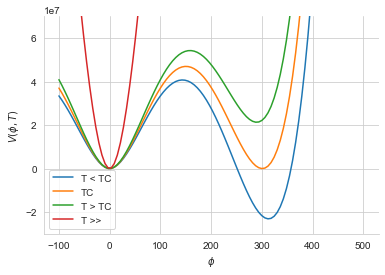

In [393]:
# T = 0 masses
mW0 = 380   #W boson mass
mZ0 = 91  #Z boson mass
mh0 = 125   #Higgs mass 
v0 = 246    #Higgs VEVss
mt0 = 100   #Top quark mass
l = mh0**2/(2*v0**2)  # lambda

# Coefficients in eq (213)
D = (2*mW0**2 + mZ0**2 + 2*mt0**2)/(8*v0**2)
E = (2*mW0**3 + mZ0**3)/(4*np.pi*v0**3)
B = 3/(64*np.pi**2*v0**4)*(2*mW0**4 + mZ0**4 - 4*mt0**4)
Tmin2 = (mh0**2 -8*B*v0**2)/(4*D)

lTemp = lambda T: l - 3*(2*mW0**4*(np.log(mW0**2/T**2) - (5.4076- 1.5))\
                    + mZ0**4*(np.log(mZ0**2/T**2) - (5.4076 -1.5)) - 4*mt0**4*(np.log(mt0**2/T**2) - (2.6351 -1.5)))/(16*np.pi**2*v0**4)

# The critical temperature according to eq (228)
critTemp = lambda TC: TC**2 - lTemp(TC)*D*Tmin2/(lTemp(TC)*D - E**2) 
# Find root of the equation
tempCrit = fsolve(critTemp, mh0)
print('Critical temperature from (228): ', np.around(tempCrit[0], 3))

# Change in lambda
print('lambda(T):', np.around(lTemp(tempCrit)[0], 3))
print('lambda:', np.around(l, 3))

phi = np.linspace(-100, 500, 100)
temp = np.linspace(105,115, 100)

def potential(phi, T):
    # Potential given by (213)
    return D*(T**2 - Tmin2)*phi**2 - E*T*np.abs(phi)**3 + lTemp(T)*phi**4/4

def dVdphi(phi, T):
    # Derivative of the potential w.r.t phi
    return 2*D*(T**2 - Tmin2)*phi - 3*E*T*phi**2 + 4*lTemp(T)*phi**3/4

def dVdT(phi, T):
    # Derivative of the potential w.r.t T
    return 2*D*T*phi**2 - E*phi**3

def equations(x):
    # The critical temperature is when we have a degenerate minimum, i.e dVdphi = 0 and V = V(phi_F) = 0.
    # Hence define a system of non-linear equations with V = 0 and dV/dphi = 0 
    phi, T = x
    V = potential(phi, T)
    dV = dVdphi(phi, T)
    return [V, dV]

# Use fsolve to find the roots of the system of equations
# Use the last point of the span of phi as an initial guess to find the right minimum, not phi_F = 0
phiAtMin, TC = fsolve(equations, [phi[-1], mh0])
print('The critical temperature, TC: ', np.around(TC, 3))
print('Value of phi at TC: ', np.around(phiAtMin, 3))

# plt.figure()
# X, Y = np.meshgrid(phi, temp)
# potentialTest = D*(Y**2 - Tmin2)*X**2 - E*Y*X**3 + lTemp(temp)*X**4/4
# fig,ax=plt.subplots(1,1)
# levels = [-0.8e6, -0.5e6, -0.2e6, 0.0, 0.1e6, 0.2e6, 0.5e6, 0.8e6]
# #levels = 0
# cp = ax.contourf(X, Y, potentialTest, levels)
# fig.colorbar(cp) # Add a colorbar to a plot


potentialTC = potential(phi, TC)
potentialTless = potential(phi, TC - 5)
potentialTmore = potential(phi, TC + 5)
potentialThigh = potential(phi, 200)


plt.figure()
#plt.plot(phi, potentialHiggs, label='T=0-ish')
plt.plot(phi, potentialTless, label='T < TC')
plt.plot(phi, potentialTC, label='TC')
plt.plot(phi, potentialTmore, label='T > TC')
plt.plot(phi, potentialThigh, label='T >>')
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$V(\phi, T)$')
plt.ylim([-3e7, 7e7])
sns.despine()

In [369]:
def dVdphiAtT(phi):
    T = getTemp()
    return 2*D*(T**2 - Tmin2)*phi - 3*E*T*phi**2 + 4*lTemp(T)*phi**3/4

In [370]:
def equations(r, y):
    """
    Function setting our equation system from the EOM of the bounce. 
    Turning equation of 2nd order ODE, to system of two 1st order ODEs.

        From: dphi^2/dr^2 + (alpha/r)*dphi/dr = dV/dphi

            introduce v = dphi/dr, s.t dv/dr = dphi^2/dr^2
            and then y = [phi, v], dy/dr = [dphi/dr, dv/dr]

        To: dy/dr = [dphi/dr, dv/dr] = [v, -(alpha/r)*dphi/dr + dV/dphi]                                              

    @param r: For T=0, r = sqrt(t^2 + x^2), for finite T r = r
           y: Array of phi and dphi/dr
           alpha: D-1 term, equals either 3 in 4D or 2 in 3D
    @return dydr: Array of dphi/dr and dphi^2/dr^2
    """
    # Pick out the values from y = [phi, v]
    phi = y[0]
    v = y[1]        # v = dphi/dr

    # Finite-T
    alpha = 2

    # Define the derivatives
    dphidr = v
    dvdr = - (alpha/r)*v + dVdphiAtT(phi)      # - (alpha/r)*v is the friction term, dVdphi(phi) the derivative of the potential (-)V(phi)
    
    # Set dy/dr = [dphi/dr, dv/dr]
    dydr = np.array([dphidr, dvdr])
    
    return dydr

In [371]:
def shooting(r, phiTrueVacuum, phiFalseVacuum, undershoot, tol):
    """
    Shooting method to find the bounce solution.

    EOM for the bounce:
    
        dphi^2/dr^2 = - (alpha/r)*dphi/dr + dV/dphi
    
    Like a point particle moving in a potential -V(phi) subject to a friction term.
    r acts as a time coordinate, and phi the spatial coordinate.

    There are two BCs for the bounce:
        1.) dphi/dr = 0 at r = 0 (no singularities in the origin, starting from rest)
        2.) phi(r) = phi_F at r = infinity  (the particle come at rest in the false vacuum phi_F when r=inf)

    We can turn this BVP to an IVP, we want to find the initial placement of the particle near the true vacuum phi_T that fulfills the BCs.
    We get the ICs:
        1.) dphi/dr = 0 at r = 0
        2.) phi(r) = phi_B at r = 0
    
    Where phi_B is the solution that fulfills BC 2.). 
    Setting dphi/dr = 0 and then an initial placement somewhere close to phi_T we get three different cases:
        a) The particle come at rest at phi_F when r = inf  (right solution, phi_B)
        b) The particle roll past phi_F (overshooting)
        c) The particle does not reach phi_F and experiences damped oscillations around the minimum (undershooting)

    When we have overshooting the initial placement of the particle is too close to phi_T and for undershooting
    it is too far from phi_T and needs to be closer. By trial and error, i.e iterate between over- and undershooting and 
    correct the intial placement until we find the right solution, case a), i.e the bounce solution phi_B.

    @param r: the "time" coordinate
           phiTrueVacuum: The value of phi at the true vacuum
           phiFalseVacuum: The value of phi at the false vacuum
           undershoot: sets the initial placement of the particle s.t we get an undershoot by phiTrueVacuum + undershoot.
           tol: Set tolerance for which we accept our numerical solution
    @return y_num: The numerical solution of the bounce

    """
    
    # Set tolerance for which we accept our numerical solution
    # and a maximum of iteration to abrupt the while loop 
    #tol = 1e-3
    max_iters = 100

    # If the inparameter 'undershoot' is None we estimate the parameter
    # Does not work atm. 
    # if undershoot is None:
    #     undershoot = (phiFalseVacuum - phiTrueVacuum)/4

    # When phi_T is placed to the right of phi_F
    if phiTrueVacuum > phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an overshoot and low an undershoot.
        high = phiTrueVacuum
        low = phiTrueVacuum - undershoot

    # When phi_T is placed to the left of phi_F
    elif phiTrueVacuum < phiFalseVacuum:
        # Set a lower and higher bound for our initial placement of the particle. 
        # Should be choosen s.t high gives an undershoot and low an overrshoot.
        high = phiTrueVacuum + undershoot
        low = phiTrueVacuum

    print('phi_T = ', phiTrueVacuum, 'phi_F = ', phiFalseVacuum)
    
    # BC 1.), dphi/dr = 0 at r = 0
    dphidr0 = 0

    # Count of iterations
    count = 0

    # Parameter needed for solve_ivp, the first and last value of r
    xspan = (r[0], r[-1])

    while count <= max_iters:
        count = count + 1

        # Set the intial guess of the placement, phi0, as the mean between over- and undershoot              
        phi0 = np.mean([low, high])

        # Collect the two initial conditions
        f0 = [phi0, dphidr0]

        # Solve our system of ODEs given as an IVP, evaluated at every point in r 
        sol = solve_ivp(equations, xspan, f0, t_eval = r)
        print(sol.message)      

        # The numerical solution from the solver
        y_num = sol.y[0, :]

        # Felsök
        print('low =', low, ', high = ', high, ', Initial guess: ', phi0)
        print('count: ', count, ', Value of last point in numerical: ', y_num[-1], ', False vacuum: ', phiFalseVacuum)

        # If the initial placement was right, i.e phi0 = phi_B we have found our solution and break
        # the while loop. check if value of the last point in our numerical solution is within tolerance to phi_F.
        if np.abs(y_num[-1] - phiFalseVacuum) <= tol:         
            break
        
        # If the solution is not at the false vacuum we have either an over- or undershoot and 
        # we need to adjust our bounds. Depending on if phi_F is either to the righ or the left 
        # of phi_T the conditions for over- and undershoot will look different.

        # When phi_T is placed to the right of phi_F
        if phiTrueVacuum > phiFalseVacuum:
            # We get an overshoot if the last point of y_num is smaller than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiFalseVacuum or y_num[-1] > phiTrueVacuum:
                high = phi0
                print('Overshoot \n')

            # elif sol.message == 'Required step size is less than spacing between numbers.':
            #     high = high -0.1
            #     print('Kaos \n')

            # In all the other cases we have an undershoot                  
            else:                           
                low = phi0
                print('Undershoot \n')  

        # When phi_T is placed to the left of phi_F
        elif phiTrueVacuum < phiFalseVacuum:
            # We get an overshoot if the last point of y_num is bigger than phi_F or if
            # it goes to +/- inf, we get the message 'Required step size is less than spacing between numbers.'
            # from solv_ivp if it has very high or low values since it stops working
            if sol.message == 'Required step size is less than spacing between numbers.'\
                or y_num[-1] < phiTrueVacuum or y_num[-1] > phiFalseVacuum:
                low = phi0
                print('Overshoot \n')

            # In all the other cases we have an undershoot
            # Fix condition                  
            else:                           
                high = phi0
                print('Undershoot \n')

        # Get dphi_B/dr needed for the Euclidean action
        dPhiB = sol.y[1, :]

    return y_num, dPhiB

In [374]:
def getTemp():
    return T

phi_T =  [305.67120933] phi_F =  0
The solver successfully reached the end of the integration interval.
low = [302.67120933] , high =  [305.67120933] , Initial guess:  304.17120932602813
count:  1 , Value of last point in numerical:  141.53091629329177 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 304.17120932602813 , high =  [305.67120933] , Initial guess:  [304.92120933]
count:  2 , Value of last point in numerical:  150.0119329790131 , False vacuum:  0


C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


Undershoot 

The solver successfully reached the end of the integration interval.
low = [304.92120933] , high =  [305.67120933] , Initial guess:  305.29620932602813
count:  3 , Value of last point in numerical:  159.9650654553226 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 305.29620932602813 , high =  [305.67120933] , Initial guess:  [305.48370933]
count:  4 , Value of last point in numerical:  166.9787066803659 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [305.48370933] , high =  [305.67120933] , Initial guess:  305.57745932602813
count:  5 , Value of last point in numerical:  167.75588629249165 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 305.57745932602813 , high =  [305.67120933] , Initial guess:  [305.62433433]
count:  6 , Value of last point in numerical:  160.4576443304456 , False vacuum:  0
Und

C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


The solver successfully reached the end of the integration interval.
low = 306.61919042457237 , high =  [308.11919042] , Initial guess:  [307.36919042]
count:  2 , Value of last point in numerical:  148.64173988699108 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [307.36919042] , high =  [308.11919042] , Initial guess:  307.74419042457237
count:  3 , Value of last point in numerical:  158.88810478869564 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 307.74419042457237 , high =  [308.11919042] , Initial guess:  [307.93169042]
count:  4 , Value of last point in numerical:  166.10342784113934 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [307.93169042] , high =  [308.11919042] , Initial guess:  308.02544042457237
count:  5 , Value of last point in numerical:  166.7827479598121 , False vacuum:  0
Undershoot 

T

C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


The solver successfully reached the end of the integration interval.
low = [310.4454021] , high =  [310.6329021] , Initial guess:  310.5391520979346
count:  5 , Value of last point in numerical:  119.2316372747501 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 310.5391520979346 , high =  [310.6329021] , Initial guess:  [310.5860271]
count:  6 , Value of last point in numerical:  121.8089355836545 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [310.5860271] , high =  [310.6329021] , Initial guess:  310.6094645979346
count:  7 , Value of last point in numerical:  134.1973986004081 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 310.6094645979346 , high =  [310.6329021] , Initial guess:  [310.62118335]
count:  8 , Value of last point in numerical:  151.8770943125842 , False vacuum:  0
Undershoot 

The solver succ

C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


The solver successfully reached the end of the integration interval.
low = 312.84469420617444 , high =  [313.21969421] , Initial guess:  [313.03219421]
count:  4 , Value of last point in numerical:  134.9498306726945 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [313.03219421] , high =  [313.21969421] , Initial guess:  313.12594420617444
count:  5 , Value of last point in numerical:  151.18595506688985 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 313.12594420617444 , high =  [313.21969421] , Initial guess:  [313.17281921]
count:  6 , Value of last point in numerical:  167.19514592175074 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [313.17281921] , high =  [313.21969421] , Initial guess:  313.19625670617444
count:  7 , Value of last point in numerical:  176.12001605164207 , False vacuum:  0
Undershoot 

T

C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


The solver successfully reached the end of the integration interval.
low = 314.38732744897817 , high =  [315.88732745] , Initial guess:  [315.13732745]
count:  2 , Value of last point in numerical:  144.12945908147 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [315.13732745] , high =  [315.88732745] , Initial guess:  315.51232744897817
count:  3 , Value of last point in numerical:  127.78274442514109 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 315.51232744897817 , high =  [315.88732745] , Initial guess:  [315.69982745]
count:  4 , Value of last point in numerical:  113.3834444078731 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [315.69982745] , high =  [315.88732745] , Initial guess:  315.79357744897817
count:  5 , Value of last point in numerical:  107.370285364564 , False vacuum:  0
Undershoot 

The so

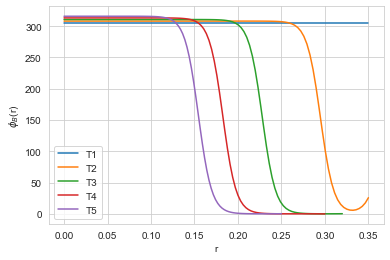

In [376]:
# Bounce solution breaks down for T1 and T2 --> not working for thin-walled bubbles.
# Thin-walled = difference in potential between the false and true vacuum is small

phi = np.linspace(-100, 300, 100)
T1 = TC-2
T = T1
phiMin = fsolve(dVdphiAtT, phi[-1])

r = np.linspace(0.00001, 0.35, 100)
phiB_num1, dPhiB_num1 = shooting(r, phiMin, 0, undershoot = 3, tol = 1)

plt.figure()
plt.plot(r, phiB_num1, label='T1')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')

T2 = TC-3
T = T2
phiMin = fsolve(dVdphiAtT, phi[-1])

r = np.linspace(0.00001, 0.35, 100)
phiB_num2, dPhiB_num2 = shooting(r, phiMin, 0, undershoot = 3, tol = 1)

plt.plot(r, phiB_num2, label='T2')

phi = np.linspace(-100, 300, 100)
T3 = TC-4
T = T3

phiMin = fsolve(dVdphiAtT, phi[-1])

r = np.linspace(0.00001, 0.32, 100)
phiB_num3, dPhiB_num3 = shooting(r, phiMin, 0, undershoot = 3, tol = 1)

plt.plot(r, phiB_num3, label='T3')


T4 = TC-5
T = T4

phiMin = fsolve(dVdphiAtT, phi[-1])

r = np.linspace(0.00001, 0.3, 100)
phiB_num4, dPhiB_num4 = shooting(r, phiMin, 0, undershoot = 3, tol = 1)

plt.plot(r, phiB_num4, label='T4')

T5 = TC-6
T = T5

phiMin = fsolve(dVdphiAtT, phi[-1])

r = np.linspace(0.00001, 0.25, 100)
phiB_num5, dPhiB_num5 = shooting(r, phiMin, 0, undershoot = 3, tol = 1)

plt.plot(r, phiB_num5, label='T5')
plt.legend()


In [379]:
# Too high values of S/T --> temperatures are too low compared to critical temperature

potentialBounce = potential(phiB_num1, T1)
integrand = r**2*(0.5*dPhiB_num1**2 + potentialBounce)
print(integrand.shape)

integral = np.trapz(integrand)
S1 = integral*4*np.pi

print(S1/T1)

potentialBounce = potential(phiB_num2, T2)
integrand = r**2*(0.5*dPhiB_num2**2 + potentialBounce)

integral = np.trapz(integrand)
S2 = integral*4*np.pi

print(S2/T2)

potentialBounce = potential(phiB_num3, T3)
integrand = r**2*(0.5*dPhiB_num3**2 + potentialBounce)

integral = np.trapz(integrand)
S3 = integral*4*np.pi

print(S3/T3)

potentialBounce = potential(phiB_num4, T4)
integrand = r**2*(0.5*dPhiB_num4**2 + potentialBounce)

integral = np.trapz(integrand)
S4 = integral*4*np.pi

print(S4/T4)

potentialBounce = potential(phiB_num5, T5)
integrand = r**2*(0.5*dPhiB_num5**2 + potentialBounce)

integral = np.trapz(integrand)
S5 = integral*4*np.pi

print(S5/T5)

(100,)
-2542496.52675493
1333691.9761570927
951953.6406195204
769848.2903679594
960328.6242465435


phi_T =  [367.79021406] phi_F =  0
Required step size is less than spacing between numbers.
low = [361.79021406] , high =  [367.79021406] , Initial guess:  364.790214059867
count:  1 , Value of last point in numerical:  -1693.816218669951 , False vacuum:  0
Overshoot 



C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
C:\Users\mvoorde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\integrate\_ivp\base.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y0 = np.asarray(y0)


Required step size is less than spacing between numbers.
low = [361.79021406] , high =  364.790214059867 , Initial guess:  [363.29021406]
count:  2 , Value of last point in numerical:  -20050.042083234006 , False vacuum:  0
Overshoot 

The solver successfully reached the end of the integration interval.
low = [361.79021406] , high =  [363.29021406] , Initial guess:  362.540214059867
count:  3 , Value of last point in numerical:  92.56733640583155 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = 362.540214059867 , high =  [363.29021406] , Initial guess:  [362.91521406]
count:  4 , Value of last point in numerical:  109.08918253772283 , False vacuum:  0
Undershoot 

The solver successfully reached the end of the integration interval.
low = [362.91521406] , high =  [363.29021406] , Initial guess:  363.102714059867
count:  5 , Value of last point in numerical:  116.50122433938485 , False vacuum:  0
Undershoot 

Required step size is

Text(0, 0.5, '$\\phi_B$(r)')

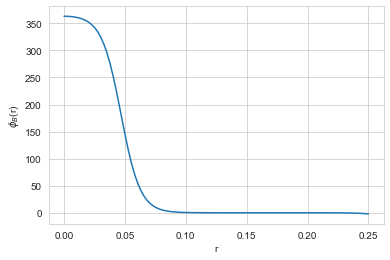

In [385]:
# Bounce works
phi = np.linspace(-100, 300, 100)
T = TC-20

phiMin = fsolve(dVdphiAtT, phi[-1])

r = np.linspace(0.00001, 0.15, 100)
phiB_num1, dPhiB_num1 = shooting(r, phiMin, 0, undershoot = 6, tol = 1e-1)

plt.figure()
plt.plot(r, phiB_num1, label='T1')
plt.xlabel('r')
plt.ylabel('$\phi_B$(r)')